In [1]:
from utils_2 import *
from keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from glob import glob
import os
import pandas as pd 
import numpy as np
from sklearn.metrics import confusion_matrix,plot_roc_curve,auc,roc_auc_score,roc_curve,cohen_kappa_score
from sklearn.utils.multiclass import unique_labels
from itertools import cycle
import re
from scipy.stats import sem, t
from sklearn.preprocessing import label_binarize
from scipy import interp

## 函数

### 非改动函数

In [2]:

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [3]:
# KS法
def Find_Optimal_Cutoff_ks(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 



In [4]:
# 约登指数
def sensivity_specifity_cutoff(y_true, y_score):
    '''Find data-driven cut-off for classification
    
    Cut-off is determied using Youden's index defined as sensitivity + specificity - 1.
    
    Parameters
    ----------
    
    y_true : array, shape = [n_samples]
        True binary labels.
        
    y_score : array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive class,
        confidence values, or non-thresholded measure of decisions (as returned by
        “decision_function” on some classifiers).
        
    References
    ----------
    
    Ewald, B. (2006). Post hoc choice of cut points introduced bias to diagnostic research.
    Journal of clinical epidemiology, 59(8), 798-801.
    
    Steyerberg, E.W., Van Calster, B., & Pencina, M.J. (2011). Performance measures for
    prediction models and markers: evaluation of predictions and classifications.
    Revista Espanola de Cardiologia (English Edition), 64(9), 788-794.
    
    Jiménez-Valverde, A., & Lobo, J.M. (2007). Threshold criteria for conversion of probability
    of species presence to either–or presence–absence. Acta oecologica, 31(3), 361-369.
    '''
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    idx = np.argmax(tpr - fpr)
    return thresholds[idx]

### 自定义类

In [5]:
class Evaluate:
    def __init__(self, model_stage, adr_list, Size_list, Doctor_score, datflag_file, data_file, test_id, score_name):
        # 初始化参数
        self.model_stage = model_stage
        self.adr_list = adr_list
        self.Size_list = Size_list
        self.Doctor_score = Doctor_score
        self.datflag_file = datflag_file
        self.data_file = data_file
        self.test_id = test_id
        self.score_name = score_name
        self.model_name_list = ['Inception', 'Vgg', 'Resnet']
        
        
       
    ## 调用该函数——读取模型并给出预测值
    def load_and_pre(self):
        # 初始化未赋值参数
        self.score_list = []
        self.Y_true = []
        self.node_id = []
        
        model_name_list = self.model_name_list
        # 为参数赋值
        model_name = 1
        print('Stage: ', self.model_stage)
        print('Model: ', model_name_list[model_name-1])
        print('View: ',self.Size_list[model_name-1])
        score_1, _, _ = self.__score_predict(model_name,adr_list[model_name-1],Size_list[model_name-1])
        ## Vgg = 2
        model_name = 2
        print('Model: ', model_name_list[model_name-1])
        print('View: ',Size_list[model_name-1])
        score_2, _, _= self.__score_predict(model_name,adr_list[model_name-1],Size_list[model_name-1])
        ## Res = 3
        model_name = 3
        print('Model: ', model_name_list[model_name-1])
        print('View: ',Size_list[model_name-1])
        score_3, Y_true, node_id = self.__score_predict(model_name,adr_list[model_name-1],Size_list[model_name-1])
        
        # 给出三个模型预测值、真实标签和对应结节id
        self.score_list = [score_1, score_2, score_3]
        self.Y_true = Y_true
        self.node_id = node_id
    
    ## 读取模型与预测值
    def __score_predict(self, model_name, model_adr, Size):
        # model_name使用模型：1为Inception，2为vgg，3为resnet
        # model_stage任务阶段
        # data文件所在位置前缀，默认为空，若非空，以/结尾
        # data_file = '/course75/RealData/'
        # datflag_file csv文件所在位置
        # 分类类别
        Class_num = get_task(self.model_stage)
        # 测试集batchsize需设置为1
        params_val = {'dim': (Size[1],Size[1],Size[1]),
                  'batch_size': 1,
                  'n_classes': Class_num,
                  'n_channels': 3,
                  'shuffle': False,
                  'Size': [Size[0],Size[1],Size[2]],
                  'data_file': self.data_file}
        partition, labels=get_par_lab(datflag_file=self.datflag_file, data_file=self.data_file, stage = self.model_stage, test_id=self.test_id)
        print('train length: ',len(partition['train']))
        print('test length: ',len(partition['test']))
        print('label length: ',len(labels))
        # Generators——仅生成测试集的生成器
        # 提取结节id
        node_id = [int(re.findall('\d+',x)[0]) for x in partition['test']]
        # generator顺序取出结节
        validation_generator = DataGenerator(partition['test'], labels, **params_val)
        # 读取模型
        model = load_model(model_adr)
        # 存储三个模型预测结果
        score = []
        Y_true = []
        for X_pre, Y_pre in validation_generator:    
            score.append(model.predict(X_pre)[0])
            Y_true.append(Y_pre)
        return score, Y_true, node_id
    
    
    def criteria(self):
#         self.Y_hat = []
#         self.Y_score = []
#         self.Y_true_list = []
        
        score_list = self.score_list
        Y_true = self.Y_true
        
        # 使用投票法
        score = np.sum(score_list, axis = 0)/3
        # 计算真实Y和预测Y
        Y_true_list=[]
        for i in range(len(Y_true)):
            temp=list(Y_true[i][0])
            Y_true_list.append(temp.index(max(temp)))
        Y_hat = []
        Y_score = []
        for i in range(len(score)):
            Y_hat.append(list(score[i]).index(max(score[i])))
            Y_score.append(score[i][1])
            
#         self.Y_hat = Y_hat
#         self.Y_score = Y_score
#         self.Y_true_list = Y_true_list
        
            
        if model_stage == 'task3':
            # 混淆矩阵
            cm = confusion_matrix(Y_true_list, Y_hat,labels = [0,1,2])
            class_names = np.array(["Grade 1","Grade 2","Grade 3"]) #按你的实际需要修改名称
            # 模型混淆矩阵
            print('********------------------模型指标-------------------********')
            plot_confusion_matrix(Y_true_list, Y_hat, classes=class_names, normalize=False) 
            plt.savefig(model_stage+'_confusion.pdf', bbox_inches='tight')
            plt.show()
            print('Acc:',sum(1 for x,y in zip(Y_true_list,Y_hat) if x == y) / len(Y_true_list)) 
            Y_true_list_doc, Y_hat_doc = doc_pred(self.Doctor_score, self.datflag_file, self.data_file, self.model_stage, self.node_id, self.score_name)
            print('Y_true一致个数:', sum(Y_true_list_doc==Y_true_list))
            # 医生混淆矩阵
            print('********------------------医生指标-------------------********')
            for i in range(0,Y_hat_doc.shape[1]):
                print('第'+str(i+1)+'个医生指标')
                plot_confusion_matrix(Y_true_list_doc,Y_hat_doc.iloc[:,i].values.tolist(), classes=class_names, normalize=False)
                plt.show()
                # 8-14
                print('Acc:',sum(1 for x,y in zip(Y_true_list_doc,Y_hat_doc.iloc[:,i].values.tolist()) if x == y) / len(Y_true_list_doc)) 
            # 绘制Task3 ROC曲线
            # 注意这里的模型输入为score，而非Y_score
            Plot_multi_ROC(Y_true_list, score, Y_true_list_doc, Y_hat_doc)
            #一致性
            print('********------------------Kappa系数：-------------------********')
            cal_kappa(self.model_stage, Y_true_list,Y_hat, Y_true_list_doc, Y_hat_doc)
            
        else:
            # 加入医生评判
            Y_true_list_doc, Y_score_doc = doc_pred(self.Doctor_score, self.datflag_file, self.data_file, self.model_stage, self.node_id, self.score_name)
            # 验证是否出现错误
            print('Y_true一致个数:', sum(Y_true_list_doc==Y_true_list))
            
            # 计算AUC与95%置信区间
            cal_AUC_all(Y_true_list,Y_score, Y_true_list_doc, Y_score_doc)
            # 绘制ROC曲线
            Plot_ROC(Y_true_list,Y_score, Y_true_list_doc, Y_score_doc)
            # 正例比例
            print('正例比例:' +str(sum(Y_true_list)/len(Y_true_list)))
            # 模型混淆矩阵
            print('********------------------模型指标-------------------********')
            multi_confusion(Y_true_list,Y_score,4)
            print('********------------------医生指标-------------------********')
            # 医生混淆矩阵
            for i in range(0,Y_score_doc.shape[1]):
                print('第'+str(i+1)+'个医生指标')
                multi_confusion(Y_true_list_doc,Y_score_doc.iloc[:,i].values.tolist(),1)
                multi_confusion(Y_true_list_doc,Y_score_doc.iloc[:,i].values.tolist(),4)
            # 计算kappa系数
            print('********------------------Kappa系数：-------------------********')
            cal_kappa(self.model_stage, Y_true_list,Y_score, Y_true_list_doc, Y_score_doc)


### 改动函数

In [6]:
##### 
def cal_multi_ft(Y_true, Y_score, n_classes=3):
    # 计算每个类别的ROC曲线和AUC面积
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    ##### 绘制模型曲线
    for i in range(n_classes):# 针对每类，拿出score和真实标签进行计算，len=75*3
        fpr[i], tpr[i], _ = roc_curve(Y_true[:, i], Y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # 计算ROC曲线和AUC面积的微观平均（micro-averaging）
    # 将真实标签和预测score直接拉平，一一对应计算，（len=225
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_true.ravel(), Y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # 首先收集所有的假正率，42个
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # 然后在此点内插所有ROC曲线
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):# interp:根据曲线fpr[i]，tpr[i]，在x=all_fpr处插值（线性）
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) # 三个分类都在42个假正率处进行插值，给出一个真阳率
    # 最终计算平均和ROC（宏观平均）
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    return fpr, tpr, roc_auc

def Plot_multi_ROC(Y_true_list,Y_score, Y_true_list_doc, Y_hat_doc):
    n_classes=3
    Y_true=label_binarize(Y_true_list, classes=[0, 1, 2])
    fpr, tpr, roc_auc=cal_multi_ft(Y_true, Y_score, n_classes)


    
    plt.figure(figsize=(5,4))
    lw = 2
    # 每个类别对应的颜色，由于为三分类，cycle在这里意义不大
    # c_map = ['aqua', 'darkorange', 'cornflowerblue']
    c_map = ['#D61C4E', 'darkorange', '#1CD6CE']
    colors = cycle(c_map)
    # 将模型的每条线存储一个元组
    m_lgd=dict()
    # 初始化所有label
    labels = []
    for i, color in zip(range(n_classes), colors):
        m_lgd[i], =plt.plot(fpr[i], tpr[i], color=color, lw=lw)
        # 存储对应折线的label
        labels.append('ROC for G{0} (AUC {1:0.4f})'
                 ''.format(i+1, roc_auc[i]))
    # marks，每个医生对应一个形状
    marks=['X','o','^','H','D','P']
    # doc_lgd 将一个医生的点存成一个元组，所有医生的点存储在doc_lgd列表内
    doc_lgd = []
    for i,mark in zip(range(0,Y_hat_doc.shape[1]),marks):
        Y_score_doc=label_binarize(Y_hat_doc.iloc[:,i], classes=[0, 1, 2])
        fpr_doc, tpr_doc, roc_auc_doc=cal_multi_ft(Y_true, Y_score_doc, n_classes)
        # 每个医生绘制3个点
        p=dict()
        for j in range(n_classes):
            # 存储对应散点
            p[j] = plt.scatter(fpr_doc[j][1], tpr_doc[j][1], color=c_map[j], s=100, marker=mark)
            print('doc:'+str(i+1)+' class:'+str(j),'fpr %0.4f'%fpr_doc[j][1],'tpr %0.4f'%tpr_doc[j][1])
        # 每个医生为一个label
        labels.append('Doctor '+str(i+1))
        doc_lgd.append(p)
    # 将线单独存储
    all_lgd = [(m_lgd[0]),(m_lgd[1]),(m_lgd[2])]
    # 将散点以医生为组存储
    for i in range(len(doc_lgd)):
        all_lgd.append((doc_lgd[i][0],doc_lgd[i][1],doc_lgd[i][2]))
    # 设置图例
#     plt.legend(all_lgd, labels,
#            scatterpoints=1, numpoints=1, handler_map={tuple: HandlerTuple(ndivide=None)},loc="right", prop={'size': 8})
    plt.legend(all_lgd, labels,
           scatterpoints=1, numpoints=1, handler_map={tuple: HandlerTuple(ndivide=None)},
               bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0, prop={'size': 8})
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('1-Specificity/FPR')
    plt.ylabel('Sensitivity/TPR')
    #plt.legend(loc="lower right")
    plt.grid(linestyle='-.')
    plt.savefig(model_stage+'_ROC.pdf', bbox_inches='tight') # 保存成PDF放大后不失真（默认保存在了当前文件夹下）
    plt.show()
    
def Plot_ROC(Y_true_list,Y_score, Y_true_list_doc, Y_score_doc):
    # 计算模型
    fpr, tpr, thresholds = roc_curve(Y_true_list, Y_score) 
    roc_auc=roc_auc_score(Y_true_list, Y_score)
    # 计算医生
    fpr_doc = dict()
    tpr_doc = dict()
    roc_auc_doc = dict()
    thresholds_doc = dict()
    for i in range(0,Y_score_doc.shape[1]):
        fpr_doc[i], tpr_doc[i], thresholds_doc[i] = roc_curve(Y_true_list_doc, Y_score_doc.iloc[:,i]) 
        roc_auc_doc[i]=roc_auc_score(Y_true_list_doc,  Y_score_doc.iloc[:,i])
    plt.figure(figsize=(5,4))
    lw = 2
    # 模型ROC
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='Our model (AUC %0.4f)' % roc_auc)
    # 医生ROC
    # 医生1-3位高年资组，4-6为低年资组
    # 高年资红色，低年资蓝绿色
    high_color = '#D61C4E' 
    low_color = '#1CD6CE'
    colors = cycle([high_color, high_color, high_color, low_color, low_color, low_color])
    marks=cycle(['o','^','s'])
    for i,color,mark in zip(range(0,Y_score_doc.shape[1]),colors,marks):
        plt.plot(fpr_doc[i], tpr_doc[i], color=color,marker=mark, markerfacecolor='none',
                 lw=1, label='Doctor'+str(i+1)+' (AUC %0.4f)' % roc_auc_doc[i])
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('1-Specificity/FPR')
    plt.ylabel('Sensitivity/TPR')
    plt.legend(loc="lower right", prop={'size': 8})
    plt.grid(linestyle='-.')
    plt.savefig(model_stage+'_ROC-DOC.pdf', bbox_inches='tight')
    plt.show()

def cal_AUC_all(Y_true_list,Y_score, Y_true_list_doc, Y_score_doc):
    print('----model AUC:',roc_auc_score(Y_true_list, Y_score),'----')
    cal_AUC_each(Y_true_list, Y_score)
    for i in range(0,Y_score_doc.shape[1]):
        print('----DOC'+str(i+1)+' AUC: ',roc_auc_score(Y_true_list_doc, Y_score_doc.iloc[:,i]),'----')
        cal_AUC_each(Y_true_list_doc, Y_score_doc.iloc[:,i])
    
def cal_AUC_each(Y_true, Y_score):
    
    n_bootstraps = 1000
    rng_seed = 72  # control reproducibility
    bootstrapped_scores = []
    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(Y_true), len(Y_true))
        if len(np.unique(np.array(Y_true)[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue
        bstr_score = roc_auc_score(np.array(Y_true)[indices], np.array(Y_score)[indices])
        bootstrapped_scores.append(bstr_score)
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    confidence_std = sorted_scores.std()
    # Computing the lower and upper bound of the 90% confidence interval
    # You can change the bounds percentiles to 0.025 and 0.975 to get
    # a 95% confidence interval instead.
    confidence_lower, confidence_upper = np.percentile(sorted_scores, (2.5, 97.5))
    print("Confidence interval for the score: [{:0.6f} - {:0.6f}]".format(
        confidence_lower, confidence_upper))
    print("Std: {:0.6f}".format(confidence_std))
    z = (roc_auc_score(Y_true, Y_score)-0.5)/confidence_std
    print('P-value (TBD)',2*t.sf(z, float('inf')))

def cal_kappa(model_stage, Y_true_list,Y_score, Y_true_list_doc, Y_score_doc):
    Y_hat_doc_all = dict()
    if model_stage=='task3':
        Y_hat_model = Y_score
        for i in range(0,Y_score_doc.shape[1]):
            Y_hat_doc_all[i] = Y_score_doc.iloc[:,i]
            print('DOC '+str(i+1)+' Kappa: ',cohen_kappa_score(Y_hat_model,Y_hat_doc_all[i]))
    else:
        best_thresholds = sensivity_specifity_cutoff(Y_true_list, Y_score)
        Y_hat_model = [0 if x<best_thresholds else 1 for x in Y_score]
        for i in range(0,Y_score_doc.shape[1]):
            Y_hat_doc_all[i] = [0 if x<0.5 else 1 for x in Y_score_doc.iloc[:,i]]
            print('DOC '+str(i+1)+' Kappa: ',cohen_kappa_score(Y_hat_model,Y_hat_doc_all[i]))
    # 输出对应预测，导出计算kappa及p值
    kappa_input = pd.DataFrame(Y_hat_doc_all)
    kappa_input['Y_hat_model']=Y_hat_model
    kappa_input.to_csv(model_stage+'_kappa_input.csv',index = False)

#Find_Optimal_Cutoff(Y_true_list, Y_score)
# 0.5阈值：mode=0
# 默认最佳阈值：mode=1
# KS最佳阈值：mode=2
def multi_confusion(Y_true_list,Y_score,mode):
    print(type(Y_score))
    fpr, tpr, thresholds = roc_curve(Y_true_list, Y_score) 
    i = np.arange(len(tpr)) # index for df
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
    if mode == 1:
        # 0.5阈值
        print('--------------0.5阈值--------------')
        best_thresholds=0.5
        print('0.5阈值：',best_thresholds)
    elif mode==2:
        print('--------------默认最佳阈值--------------')
        best_thresholds=float(roc.iloc[(roc.tf-0).abs().argsort()[:1]]['thresholds'])
        print('默认最佳阈值：',best_thresholds)
    elif mode==3:
        print('--------------KS最佳阈值--------------')
        best_thresholds = Find_Optimal_Cutoff_ks(Y_true_list, Y_score)
        print('KS最佳阈值：',best_thresholds)
    elif mode==4:
        print('--------------Youden最佳阈值--------------')
        best_thresholds = sensivity_specifity_cutoff(Y_true_list, Y_score)
        print('Youden最佳阈值：',best_thresholds)
    elif mode==5:
        print('--------------正例比例阈值--------------')
        best_thresholds = sum(Y_true_list)/len(Y_true_list)
        print('正例比例：',best_thresholds)
    Y_hat_best = []
    for i in range(len(Y_score)):
        if Y_score[i]>=best_thresholds: ### 注意这里统一为大于等于
            Y_hat_best.append(1)
        else:
            Y_hat_best.append(0)  
    # 输出混淆矩阵
    cm = confusion_matrix(Y_true_list, Y_hat_best,labels = [0,1])
    print(cm)
    if model_stage == 'task1':
        class_names = np.array(["Benign","Malignance"]) #按你的实际需要修改名称
    if model_stage == 'task2':
        class_names = np.array(["Pre-invasive","Invasive"]) #按你的实际需要修改名称
    plot_confusion_matrix(Y_true_list, Y_hat_best, classes=class_names, normalize=False)
    plt.savefig(model_stage+'-'+str(mode)+'.pdf', bbox_inches='tight')
    plt.show()
    print('Acc:',sum(1 for x,y in zip(Y_true_list,Y_hat_best) if x == y) / len(Y_true_list))
    print('灵敏度:',cm[1][1]/(cm[1][1]+cm[1][0]))
    print('特异度:',cm[0][0]/(cm[0][1]+cm[0][0]))
    print('PPV:',cm[1][1]/(cm[1][1]+cm[0][1])) # TP/(TP+FP)
    print('NPV:',cm[0][0]/(cm[0][0]+cm[1][0]))
    print('F1:',2*cm[1][1]/(2*cm[1][1]+cm[0][1]+cm[1][0]))

def doc_pred(Doctor_score, datflag_file, data_file, stage, node_id, score_name):#score_name='Task1_prob'//['Task1_prob1','Task1_prob2','Task1_prob3','Task1_prob4','Task1_prob5']
    # 表连接获得Y_true
    datflag = pd.read_csv(datflag_file)[['ID','X','Y','Z','flag']]
    # 右连接以继承datflag的index，保证医生评分顺序与测试集一致
    Doctor_Pred = pd.merge(Doctor_score,datflag,on=['ID','X','Y','Z'],how='right')
    Doctor_Pred['Y_true'] = 1
    if stage == 'task1':
        Doctor_Pred.loc[Doctor_Pred.apply(lambda x: x['flag'] == '良性', axis=1),'Y_true'] = 0
    elif stage == 'task2':
        Doctor_Pred = pd.DataFrame(Doctor_Pred.loc[Doctor_Pred['flag']!='良性',])
        Doctor_Pred.loc[Doctor_Pred.apply(lambda x: x['flag'] == '浸润前病变', axis=1),'Y_true'] = 0
    else:
        Doctor_Pred = pd.DataFrame(Doctor_Pred.loc[Doctor_Pred.apply(lambda x: x['flag'] in ['grade1','grade2','grade3'], axis=1),])
        Doctor_Pred.loc[Doctor_Pred.apply(lambda x: x['flag'] == 'grade1', axis=1),'Y_true'] = 0
        Doctor_Pred.loc[Doctor_Pred.apply(lambda x: x['flag'] == 'grade3', axis=1),'Y_true'] = 2
    Doctor_Pred = Doctor_Pred.loc[node_id,]
    print('doc_score len:',len(Doctor_Pred))
#     print('Null distrbt:',Doctor_Pred[score_name].isna().sum())
#     print('doc score shape',Doctor_Pred[score_name].shape)
    return Doctor_Pred['Y_true'], Doctor_Pred[score_name]



## 设置参数

In [7]:
# 设置文件位置
datflag_file = 'datflag641-plus.csv'
data_file = '/course75/RealData/'

# 给定模型测试集患者id
test_id = list(range(285,293))
test_id.extend(list(range(419,439)))
test_id.extend(list(range(1,84)))
test_id.extend(list(range(439,468)))
test_id.extend(list(range(637,642)))
test_id.extend([259,294])

print('当前实际test长度',len(test_id))

当前实际test长度 147


## 准备医生数据
- 注意，当医生增加，添加Task1_prob2、Task1_prob3...等列，并更改各task的score_name4
- 注意task1、2的score=(评分-1)/4，task3的score=评分-1
- 当前手动更改第68号病人第一个结节位置

In [8]:
# 读取数据
Doctor_file_1 = 'doctor/医生1-last5.csv'
Doctor_file_2 = 'doctor/医生2-last5.csv'
Doctor_file_3 = 'doctor/医生3-last5.csv'
Doctor_file_4 = 'doctor/医生4-last5.csv'
Doctor_file_5 = 'doctor/医生5-last5.csv'
Doctor_file_6 = 'doctor/医生6-last5.csv'
Doctor_score_1 = pd.read_csv(Doctor_file_1).iloc[:,0:9]
Doctor_score_2 = pd.read_csv(Doctor_file_2).iloc[:,0:9]
Doctor_score_3 = pd.read_csv(Doctor_file_3).iloc[:,0:9]
Doctor_score_4 = pd.read_csv(Doctor_file_4).iloc[:,0:9]
Doctor_score_5 = pd.read_csv(Doctor_file_5).iloc[:,0:9]
Doctor_score_6 = pd.read_csv(Doctor_file_6).iloc[:,0:9]
Doctor_score_3

,ID_new,X,Y,Z,lung,position,良恶性（1-5打分，1为非常像良性，5为非常向恶性）,IA vs pre-IA（1-5打分，1为非常像浸润前，5为非常像浸润后）,grade（1=附壁型为主；2=腺泡型或乳头型；3=微乳头实体型或复杂腺体型大于20%）
0,1,180,276,77-94,右肺,上叶,5,5.0,3.0
1,2,133,285,80-82,右肺,上叶,2,1.0,NaN
2,2,172,345,83-85,右肺,上叶,2,1.0,NaN
3,2,123,259,85-99,右肺,上叶,2,1.0,NaN
4,2,227,297,97-99,右肺,上叶,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...
287,467,385,195,266-295,左肺,下叶,5,5.0,3.0
288,638,190,312,38-45,右肺,上叶,5,5.0,1.0
289,639,153,307,60-67,右肺,上叶,4,1.0,1.0
290,640,134,335,142-151,右肺,下叶,5,4.0,1.0


In [9]:
# 将空值均替换为1
# Doctor_score.fillna(1, inplace = True)
# 以医生1为基本生成score列
# task1
Doctor_score_1['Task1_prob1']=(Doctor_score_1.loc[:,'良恶性（1-5打分，1为非常像良性，5为非常向恶性）']-1)/4
Doctor_score_1['Task1_prob2']=(Doctor_score_2.loc[:,'良恶性（1-5打分，1为非常像良性，5为非常向恶性）']-1)/4
Doctor_score_1['Task1_prob3']=(Doctor_score_3.loc[:,'良恶性（1-5打分，1为非常像良性，5为非常向恶性）']-1)/4
Doctor_score_1['Task1_prob4']=(Doctor_score_4.loc[:,'良恶性（1-5打分，1为非常像良性，5为非常向恶性）']-1)/4
Doctor_score_1['Task1_prob5']=(Doctor_score_5.loc[:,'良恶性（1-5打分，1为非常像良性，5为非常向恶性）']-1)/4
Doctor_score_1['Task1_prob6']=(Doctor_score_6.loc[:,'良恶性（1-5打分，1为非常像良性，5为非常向恶性）']-1)/4
# task2
Doctor_score_1['Task2_prob1']=(Doctor_score_1.loc[:,'IA vs pre-IA（1-5打分，1为非常像浸润前，5为非常像浸润后）']-1)/4
Doctor_score_1['Task2_prob2']=(Doctor_score_2.loc[:,'IA vs pre-IA（1-5打分，1为非常像浸润前，5为非常像浸润后）']-1)/4
Doctor_score_1['Task2_prob3']=(Doctor_score_3.loc[:,'IA vs pre-IA（1-5打分，1为非常像浸润前，5为非常像浸润后）']-1)/4
Doctor_score_1['Task2_prob4']=(Doctor_score_4.loc[:,'IA vs pre-IA（1-5打分，1为非常像浸润前，5为非常像浸润后）']-1)/4
Doctor_score_1['Task2_prob5']=(Doctor_score_5.loc[:,'IA vs pre-IA（1-5打分，1为非常像浸润前，5为非常像浸润后）']-1)/4
Doctor_score_1['Task2_prob6']=(Doctor_score_6.loc[:,'IA vs pre-IA（1-5打分，1为非常像浸润前，5为非常像浸润后）']-1)/4
# 注意task3的取值要在0-2之间
Doctor_score_1['Task3_prob1']=Doctor_score_1.loc[:,'grade（1=附壁型为主；2=腺泡型或乳头型；3=微乳头实体型或复杂腺体型大于20%）']-1
Doctor_score_1['Task3_prob2']=Doctor_score_2.loc[:,'grade（1=附壁型为主；2=腺泡型或乳头型；3=微乳头实体型或复杂腺体型大于20%）']-1
Doctor_score_1['Task3_prob3']=Doctor_score_3.loc[:,'grade（1=附壁型为主；2=腺泡型或乳头型；3=微乳头实体型或复杂腺体型大于20%）']-1
Doctor_score_1['Task3_prob4']=Doctor_score_4.loc[:,'grade（1=附壁型为主；2=腺泡型或乳头型；3=微乳头实体型或复杂腺体型大于20%）']-1
Doctor_score_1['Task3_prob5']=Doctor_score_5.loc[:,'grade（1=附壁型为主；2=腺泡型或乳头型；3=微乳头实体型或复杂腺体型大于20%）']-1
Doctor_score_1['Task3_prob6']=Doctor_score_6.loc[:,'grade（1=附壁型为主；2=腺泡型或乳头型；3=微乳头实体型或复杂腺体型大于20%）']-1

Doctor_score_1.rename(columns={'ID_new': 'ID'}, inplace=True)
# 注意68号病人第一个结节位置标错了，暂时手动与datflag对其
index_68 = Doctor_score_1.loc[Doctor_score_1['ID']==68,].index[0]
Doctor_score_1.loc[index_68,['X','Y','Z']]=[186,199,'112-121']
Doctor_score_1.loc[Doctor_score_1['ID']==68,]

,ID,X,Y,Z,lung,position,良恶性（1-5打分，1为非常像良性，5为非常向恶性）,IA vs pre-IA（1-5打分，1为非常像浸润前，5为非常像浸润后）,grade（1=附壁型为主；2=腺泡型或乳头型；3=微乳头实体型或复杂腺体型大于20%）,Task1_prob1,...,Task2_prob3,Task2_prob4,Task2_prob5,Task2_prob6,Task3_prob1,Task3_prob2,Task3_prob3,Task3_prob4,Task3_prob5,Task3_prob6
146,68,186,199,112-121,右肺,上叶,5,1.0,NaN,1.0,...,0.0,1.0,0.5,0.00,NaN,NaN,NaN,1.0,0.0,NaN
147,68,145,297,215-230,右肺,中叶,5,5.0,3.0,1.0,...,1.0,1.0,1.0,0.75,2.0,1.0,1.0,2.0,1.0,1.0


In [10]:
# 将空值均替换为0
Doctor_score_1.fillna(0, inplace = True)
Doctor_score = Doctor_score_1
Doctor_score

,ID,X,Y,Z,lung,position,良恶性（1-5打分，1为非常像良性，5为非常向恶性）,IA vs pre-IA（1-5打分，1为非常像浸润前，5为非常像浸润后）,grade（1=附壁型为主；2=腺泡型或乳头型；3=微乳头实体型或复杂腺体型大于20%）,Task1_prob1,...,Task2_prob3,Task2_prob4,Task2_prob5,Task2_prob6,Task3_prob1,Task3_prob2,Task3_prob3,Task3_prob4,Task3_prob5,Task3_prob6
0,1,180,276,77-94,右肺,上叶,5,5.0,3.0,1.00,...,1.00,1.00,0.50,1.00,2.0,2.0,2.0,2.0,0.0,1.0
1,2,133,285,80-82,右肺,上叶,5,1.0,0.0,1.00,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,2,172,345,83-85,右肺,上叶,4,2.0,0.0,0.75,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,2,123,259,85-99,右肺,上叶,5,5.0,2.0,1.00,...,0.00,0.00,0.25,0.00,1.0,0.0,0.0,0.0,0.0,0.0
4,2,227,297,97-99,右肺,上叶,4,2.0,0.0,0.75,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,467,385,195,266-295,左肺,下叶,5,5.0,3.0,1.00,...,1.00,1.00,0.75,1.00,2.0,2.0,2.0,2.0,0.0,2.0
288,638,190,312,38-45,右肺,上叶,5,5.0,1.0,1.00,...,1.00,1.00,1.00,1.00,0.0,0.0,0.0,0.0,0.0,0.0
289,639,153,307,60-67,右肺,上叶,4,1.0,1.0,0.75,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
290,640,134,335,142-151,右肺,下叶,5,4.0,1.0,1.00,...,0.75,0.75,0.75,0.75,0.0,0.0,0.0,0.0,0.0,0.0


## 指标计算

### task 1

In [138]:
# 多名医生更改score_name
# **通过修改score_name可以调整医生顺序
score_name=['Task1_prob2','Task1_prob5','Task1_prob6','Task1_prob1','Task1_prob3','Task1_prob4']
# 当前阶段
model_stage = 'task1'
# 各模型所在位置
Incpt_file_adr = 'model-cut2/'+model_stage+'/'+'Inception_60_Epoch.41-0.8504.h5'
Vgg_file_adr = 'model-cut2/'+model_stage+'/'+'Vgg_40_Epoch.08-0.8419.h5'
Res_file_adr = 'model-cut2/'+model_stage+'/'+'Resnet_60_Epoch.54-0.8590.h5'
adr_list = [Incpt_file_adr, Vgg_file_adr, Res_file_adr]
# 目标视野
Size_list = [[80, 60, 40], [60, 40, 20], [80, 60, 40]]
My_eva = Evaluate(model_stage, adr_list, Size_list, Doctor_score, datflag_file, data_file, test_id, score_name)
My_eva.load_and_pre()

Stage:  task1
Model:  Inception
View:  [80, 60, 40]
Current task stage: task1
train length:  13700
test length:  232
label length:  13932
Model:  Vgg
View:  [60, 40, 20]
Current task stage: task1
train length:  13700
test length:  232
label length:  13932
Model:  Resnet
View:  [80, 60, 40]
Current task stage: task1
train length:  13700
test length:  232
label length:  13932


doc_score len: 232
Y_true一致个数: 232
----model AUC: 0.8921911421911423 ----
Confidence interval for the score: [0.842403 - 0.934552]
Std: 0.023162
P-value (TBD) 2.5799384304950738e-64
----DOC1 AUC:  0.86005661005661 ----
Confidence interval for the score: [0.802464 - 0.910524]
Std: 0.027320
P-value (TBD) 1.1532858135554195e-39
----DOC2 AUC:  0.6002331002331003 ----
Confidence interval for the score: [0.524505 - 0.669775]
Std: 0.038747
P-value (TBD) 0.009685864902941682
----DOC3 AUC:  0.577006327006327 ----
Confidence interval for the score: [0.499731 - 0.659867]
Std: 0.041687
P-value (TBD) 0.06471238891583136
----DOC4 AUC:  0.6973026973026972 ----
Confidence interval for the score: [0.627135 - 0.774190]
Std: 0.036337
P-value (TBD) 5.6405458200141684e-08
----DOC5 AUC:  0.7224858474858475 ----
Confidence interval for the score: [0.650238 - 0.795219]
Std: 0.037827
P-value (TBD) 4.059890483188164e-09
----DOC6 AUC:  0.7261072261072261 ----
Confidence interval for the score: [0.657683 - 0.7955

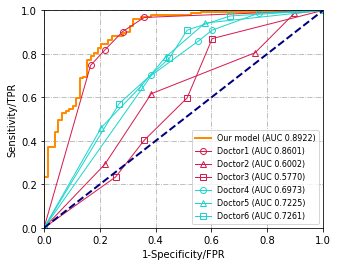

正例比例:0.6637931034482759
********------------------模型指标-------------------********
<class 'list'>
--------------Youden最佳阈值--------------
Youden最佳阈值： 0.6021514
[[ 53  25]
 [  6 148]]


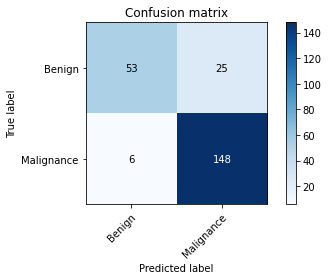

Acc: 0.8663793103448276
灵敏度: 0.961038961038961
特异度: 0.6794871794871795
PPV: 0.8554913294797688
NPV: 0.8983050847457628
F1: 0.9051987767584098
********------------------医生指标-------------------********
第1个医生指标
<class 'list'>
--------------0.5阈值--------------
0.5阈值： 0.5
[[ 56  22]
 [ 15 139]]


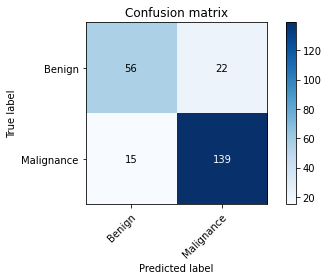

Acc: 0.8405172413793104
灵敏度: 0.9025974025974026
特异度: 0.717948717948718
PPV: 0.8633540372670807
NPV: 0.7887323943661971
F1: 0.8825396825396825
<class 'list'>
--------------Youden最佳阈值--------------
Youden最佳阈值： 0.5
[[ 56  22]
 [ 15 139]]


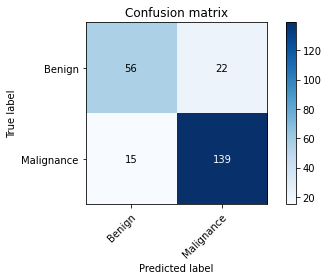

Acc: 0.8405172413793104
灵敏度: 0.9025974025974026
特异度: 0.717948717948718
PPV: 0.8633540372670807
NPV: 0.7887323943661971
F1: 0.8825396825396825
第2个医生指标
<class 'list'>
--------------0.5阈值--------------
0.5阈值： 0.5
[[ 19  59]
 [ 30 124]]


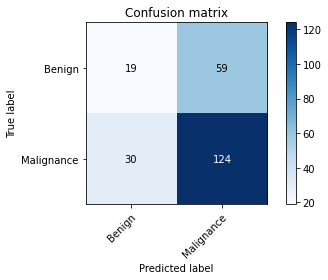

Acc: 0.6163793103448276
灵敏度: 0.8051948051948052
特异度: 0.24358974358974358
PPV: 0.6775956284153005
NPV: 0.3877551020408163
F1: 0.7359050445103857
<class 'list'>
--------------Youden最佳阈值--------------
Youden最佳阈值： 0.75
[[48 30]
 [59 95]]


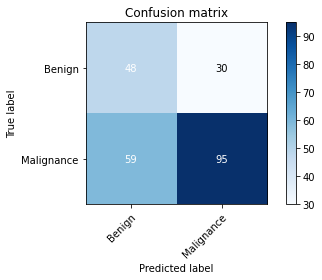

Acc: 0.6163793103448276
灵敏度: 0.6168831168831169
特异度: 0.6153846153846154
PPV: 0.76
NPV: 0.4485981308411215
F1: 0.6810035842293907
第3个医生指标
<class 'list'>
--------------0.5阈值--------------
0.5阈值： 0.5
[[38 40]
 [62 92]]


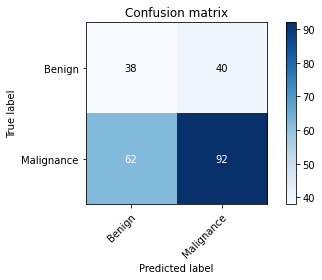

Acc: 0.5603448275862069
灵敏度: 0.5974025974025974
特异度: 0.48717948717948717
PPV: 0.696969696969697
NPV: 0.38
F1: 0.6433566433566433
<class 'list'>
--------------Youden最佳阈值--------------
Youden最佳阈值： 0.25
[[ 31  47]
 [ 20 134]]


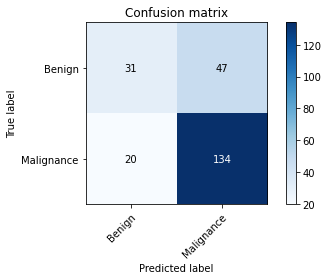

Acc: 0.7112068965517241
灵敏度: 0.8701298701298701
特异度: 0.3974358974358974
PPV: 0.7403314917127072
NPV: 0.6078431372549019
F1: 0.8
第4个医生指标
<class 'list'>
--------------0.5阈值--------------
0.5阈值： 0.5
[[ 31  47]
 [ 14 140]]


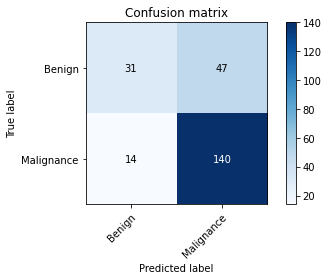

Acc: 0.7370689655172413
灵敏度: 0.9090909090909091
特异度: 0.3974358974358974
PPV: 0.7486631016042781
NPV: 0.6888888888888889
F1: 0.8211143695014663
<class 'list'>
--------------Youden最佳阈值--------------
Youden最佳阈值： 1.0
[[ 48  30]
 [ 46 108]]


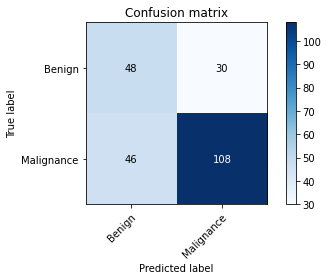

Acc: 0.6724137931034483
灵敏度: 0.7012987012987013
特异度: 0.6153846153846154
PPV: 0.782608695652174
NPV: 0.5106382978723404
F1: 0.7397260273972602
第5个医生指标
<class 'list'>
--------------0.5阈值--------------
0.5阈值： 0.5
[[ 44  34]
 [ 33 121]]


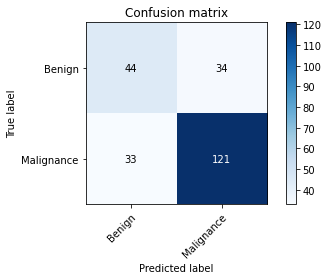

Acc: 0.7112068965517241
灵敏度: 0.7857142857142857
特异度: 0.5641025641025641
PPV: 0.7806451612903226
NPV: 0.5714285714285714
F1: 0.7831715210355987
<class 'list'>
--------------Youden最佳阈值--------------
Youden最佳阈值： 0.25
[[ 33  45]
 [  9 145]]


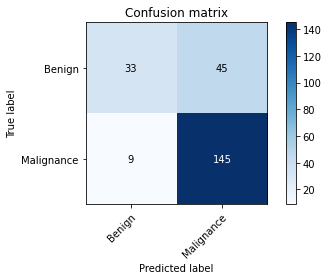

Acc: 0.7672413793103449
灵敏度: 0.9415584415584416
特异度: 0.4230769230769231
PPV: 0.7631578947368421
NPV: 0.7857142857142857
F1: 0.8430232558139535
第6个医生指标
<class 'list'>
--------------0.5阈值--------------
0.5阈值： 0.5
[[ 38  40]
 [ 14 140]]


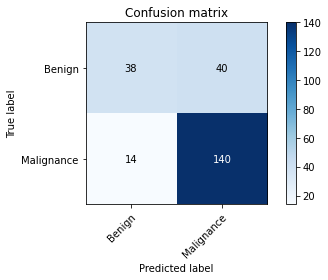

Acc: 0.7672413793103449
灵敏度: 0.9090909090909091
特异度: 0.48717948717948717
PPV: 0.7777777777777778
NPV: 0.7307692307692307
F1: 0.8383233532934131
<class 'list'>
--------------Youden最佳阈值--------------
Youden最佳阈值： 0.5
[[ 38  40]
 [ 14 140]]


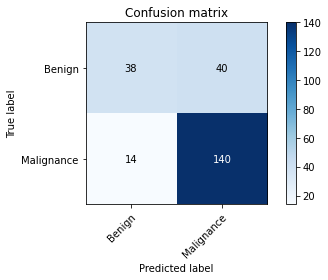

Acc: 0.7672413793103449
灵敏度: 0.9090909090909091
特异度: 0.48717948717948717
PPV: 0.7777777777777778
NPV: 0.7307692307692307
F1: 0.8383233532934131
********------------------Kappa系数：-------------------********
DOC 1 Kappa:  0.6165641355247452
DOC 2 Kappa:  0.08519248728857531
DOC 3 Kappa:  0.10299744897959184
DOC 4 Kappa:  0.40822616643639065
DOC 5 Kappa:  0.29778331701237426
DOC 6 Kappa:  0.3968189233278956


In [139]:
My_eva.criteria()

### task2

In [133]:
# 通过修改score_name可以调整医生顺序
score_name=['Task2_prob2','Task2_prob5','Task2_prob6','Task2_prob1','Task2_prob3','Task2_prob4']
model_stage = 'task2'
# 各模型所在位置
Incpt_file_adr = 'model-cut2/'+model_stage+'/'+'Inception_40_Epoch.82-0.8599.h5'
Vgg_file_adr = 'model-cut2/'+model_stage+'/'+'Vgg_60_Epoch.17-0.8535.h5'
Res_file_adr = 'model-cut2/'+model_stage+'/'+'Resnet_40_Epoch.09-0.8408.h5'
adr_list = [Incpt_file_adr, Vgg_file_adr, Res_file_adr]
# 目标视野
Size_list = [[60, 40, 20], [80, 60, 40], [60, 40, 20]]
My_eva = Evaluate(model_stage, adr_list, Size_list, Doctor_score, datflag_file, data_file, test_id, score_name)
My_eva.load_and_pre()

Stage:  task2
Model:  Inception
View:  [60, 40, 20]
Current task stage: task2
train length:  10158
test length:  154
label length:  10312
Model:  Vgg
View:  [80, 60, 40]
Current task stage: task2
train length:  10158
test length:  154
label length:  10312
Model:  Resnet
View:  [60, 40, 20]
Current task stage: task2
train length:  10158
test length:  154
label length:  10312


doc_score len: 154
Y_true一致个数: 154
----model AUC: 0.9254385964912281 ----
Confidence interval for the score: [0.878756 - 0.962678]
Std: 0.021277
P-value (TBD) 6.094628698848293e-89
----DOC1 AUC:  0.9038461538461539 ----
Confidence interval for the score: [0.847165 - 0.950258]
Std: 0.026157
P-value (TBD) 8.874533073672187e-54
----DOC2 AUC:  0.8712044534412955 ----
Confidence interval for the score: [0.809885 - 0.925343]
Std: 0.029136
P-value (TBD) 3.520017389461158e-37
----DOC3 AUC:  0.8660593792172739 ----
Confidence interval for the score: [0.802672 - 0.922350]
Std: 0.030805
P-value (TBD) 1.4490565965468382e-32
----DOC4 AUC:  0.7992577597840755 ----
Confidence interval for the score: [0.732044 - 0.860180]
Std: 0.033659
P-value (TBD) 6.069230943825296e-19
----DOC5 AUC:  0.8006072874493928 ----
Confidence interval for the score: [0.727801 - 0.866415]
Std: 0.035987
P-value (TBD) 6.641374171997671e-17
----DOC6 AUC:  0.7268893387314439 ----
Confidence interval for the score: [0.653138 - 0.

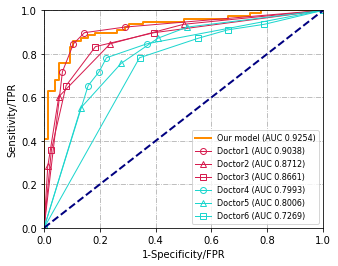

正例比例:0.5064935064935064
********------------------模型指标-------------------********
<class 'list'>
--------------Youden最佳阈值--------------
Youden最佳阈值： 0.5623825
[[68  8]
 [11 67]]


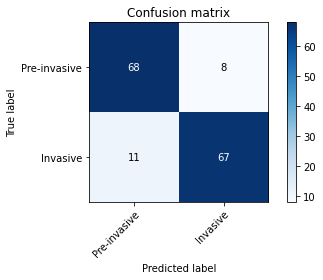

Acc: 0.8766233766233766
灵敏度: 0.8589743589743589
特异度: 0.8947368421052632
PPV: 0.8933333333333333
NPV: 0.8607594936708861
F1: 0.8758169934640523
********------------------医生指标-------------------********
第1个医生指标
<class 'list'>
--------------0.5阈值--------------
0.5阈值： 0.5
[[65 11]
 [ 8 70]]


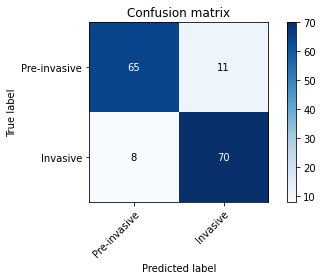

Acc: 0.8766233766233766
灵敏度: 0.8974358974358975
特异度: 0.8552631578947368
PPV: 0.8641975308641975
NPV: 0.8904109589041096
F1: 0.8805031446540881
<class 'list'>
--------------Youden最佳阈值--------------
Youden最佳阈值： 0.5
[[65 11]
 [ 8 70]]


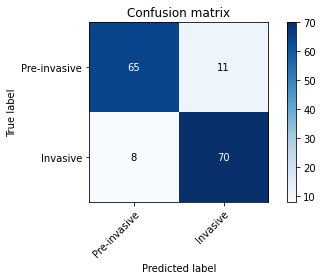

Acc: 0.8766233766233766
灵敏度: 0.8974358974358975
特异度: 0.8552631578947368
PPV: 0.8641975308641975
NPV: 0.8904109589041096
F1: 0.8805031446540881
第2个医生指标
<class 'list'>
--------------0.5阈值--------------
0.5阈值： 0.5
[[58 18]
 [12 66]]


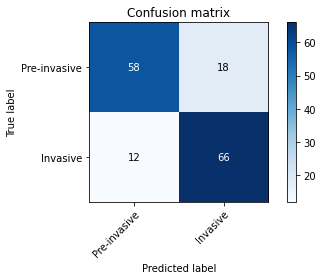

Acc: 0.8051948051948052
灵敏度: 0.8461538461538461
特异度: 0.7631578947368421
PPV: 0.7857142857142857
NPV: 0.8285714285714286
F1: 0.8148148148148148
<class 'list'>
--------------Youden最佳阈值--------------
Youden最佳阈值： 0.5
[[58 18]
 [12 66]]


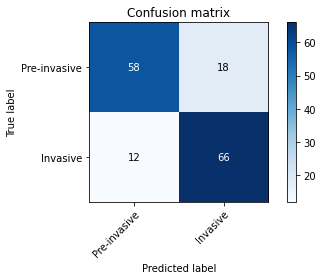

Acc: 0.8051948051948052
灵敏度: 0.8461538461538461
特异度: 0.7631578947368421
PPV: 0.7857142857142857
NPV: 0.8285714285714286
F1: 0.8148148148148148
第3个医生指标
<class 'list'>
--------------0.5阈值--------------
0.5阈值： 0.5
[[62 14]
 [13 65]]


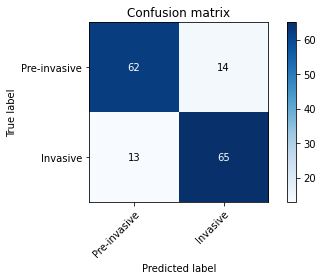

Acc: 0.8246753246753247
灵敏度: 0.8333333333333334
特异度: 0.8157894736842105
PPV: 0.8227848101265823
NPV: 0.8266666666666667
F1: 0.8280254777070064
<class 'list'>
--------------Youden最佳阈值--------------
Youden最佳阈值： 0.5
[[62 14]
 [13 65]]


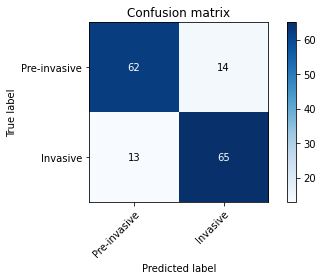

Acc: 0.8246753246753247
灵敏度: 0.8333333333333334
特异度: 0.8157894736842105
PPV: 0.8227848101265823
NPV: 0.8266666666666667
F1: 0.8280254777070064
第4个医生指标
<class 'list'>
--------------0.5阈值--------------
0.5阈值： 0.5
[[59 17]
 [17 61]]


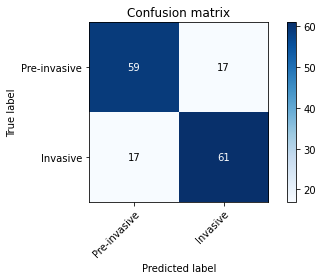

Acc: 0.7792207792207793
灵敏度: 0.782051282051282
特异度: 0.7763157894736842
PPV: 0.782051282051282
NPV: 0.7763157894736842
F1: 0.782051282051282
<class 'list'>
--------------Youden最佳阈值--------------
Youden最佳阈值： 0.5
[[59 17]
 [17 61]]


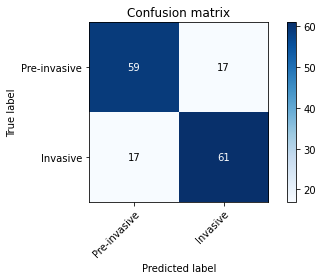

Acc: 0.7792207792207793
灵敏度: 0.782051282051282
特异度: 0.7763157894736842
PPV: 0.782051282051282
NPV: 0.7763157894736842
F1: 0.782051282051282
第5个医生指标
<class 'list'>
--------------0.5阈值--------------
0.5阈值： 0.5
[[45 31]
 [10 68]]


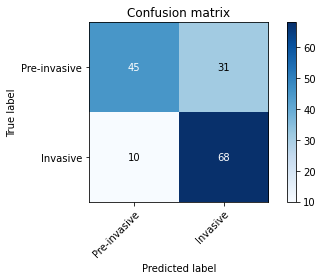

Acc: 0.7337662337662337
灵敏度: 0.8717948717948718
特异度: 0.5921052631578947
PPV: 0.6868686868686869
NPV: 0.8181818181818182
F1: 0.768361581920904
<class 'list'>
--------------Youden最佳阈值--------------
Youden最佳阈值： 0.75
[[55 21]
 [19 59]]


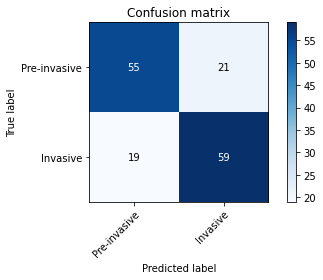

Acc: 0.7402597402597403
灵敏度: 0.7564102564102564
特异度: 0.7236842105263158
PPV: 0.7375
NPV: 0.7432432432432432
F1: 0.7468354430379747
第6个医生指标
<class 'list'>
--------------0.5阈值--------------
0.5阈值： 0.5
[[26 50]
 [ 7 71]]


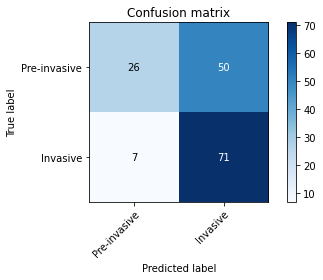

Acc: 0.6298701298701299
灵敏度: 0.9102564102564102
特异度: 0.34210526315789475
PPV: 0.5867768595041323
NPV: 0.7878787878787878
F1: 0.7135678391959799
<class 'list'>
--------------Youden最佳阈值--------------
Youden最佳阈值： 1.0
[[50 26]
 [17 61]]


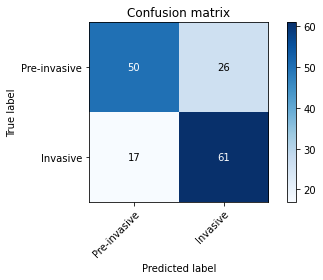

Acc: 0.7207792207792207
灵敏度: 0.782051282051282
特异度: 0.6578947368421053
PPV: 0.7011494252873564
NPV: 0.746268656716418
F1: 0.7393939393939394
********------------------Kappa系数：-------------------********
DOC 1 Kappa:  0.7146707091123463
DOC 2 Kappa:  0.7020023557126032
DOC 3 Kappa:  0.5846957694252486
DOC 4 Kappa:  0.6494688922610015
DOC 5 Kappa:  0.5101289134438305
DOC 6 Kappa:  0.3089579524680073


In [134]:
My_eva.criteria()

### task3

In [11]:
score_name=['Task3_prob1','Task3_prob2','Task3_prob3','Task3_prob4','Task3_prob5','Task3_prob6']
model_stage = 'task3'
# 各模型所在位置
Incpt_file_adr = 'model-cut2/'+model_stage+'/'+'Inception_60_Epoch.44-0.7105.h5'
Vgg_file_adr = 'model-cut2/'+model_stage+'/'+'Vgg_80_Epoch.09-0.7237.h5'
Res_file_adr = 'model-cut2/'+model_stage+'/'+'Resnet_40_Epoch.04-0.7237.h5'
adr_list = [Incpt_file_adr, Vgg_file_adr, Res_file_adr]
# 目标视野
Size_list = [[80, 60, 40], [100, 80, 60], [60, 40, 20]]
# 用来测试的第二个医生
My_eva = Evaluate(model_stage, adr_list, Size_list, Doctor_score, datflag_file, data_file, test_id, score_name)
My_eva.load_and_pre()

Stage:  task3
Model:  Inception
View:  [80, 60, 40]
Current task stage: task3
train length:  4989
test length:  76
label length:  5065


OSError: No file or directory found at model-cut2/task3/Inception_60_Epoch.44-0.7105.h5

In [ ]:
My_eva.criteria()